## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

In [2]:
# usado para igualar el largo de los años, necesario para aplicar PCA
dia_maximo = 365
USE_CUMSUM = True

grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
grupos_etarios_legends = ["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]

In [3]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis

common_filter = """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and CodigoRegion is not null
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by CodigoDependencia, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(dia_maximo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'Menores_1' as grupo_etario
    , sum(Menores_1) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'De_1_a_4' as grupo_etario
    , sum(De_1_a_4) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_5_a_14' as grupo_etario
    , sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_15_a_64'  as grupo_etario
    , sum(De_15_a_64) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_65_y_mas' as grupo_etario
    , sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion','grupo_etario','nrodia']).reset_index(drop = True)

In [4]:
#the cumulative sum is taken on each of the classes, 
#is this case we group by "year", "CodigoRegion" and "grupo_etario"
#the result is a dataframe with the "nro_dia" in the columns, 
#in which the cumulative information of the demand, scaled from 0 to 1 is stored
groups = df2[["year","CodigoRegion","grupo_etario"]].drop_duplicates()
df_aux =df2.copy()
for (index, year, region, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoRegion'] == region) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoRegion','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()

In [6]:
#Analisis PCA

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(dia_maximo)]].values

# Separating out the target
y = df3.loc[:,['CodigoRegion','grupo_etario']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['CodigoRegion','grupo_etario']]], axis = 1)


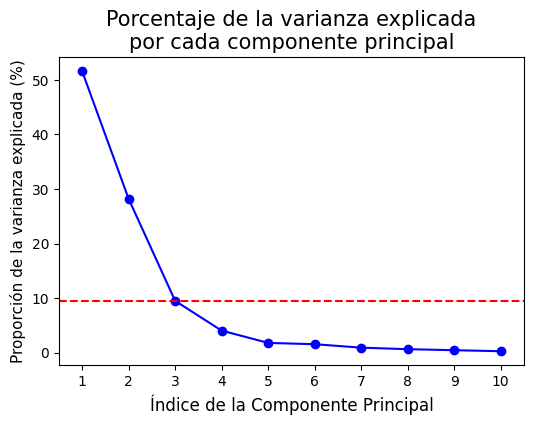

In [7]:
#Ilustracion 6: Grafica de la varianza explicada por cada componente principal
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1) 
plt.plot([k+1 for k in range(pca.n_components_)],100*pca.explained_variance_ratio_,'-bo')
plt.axhline(y = 100*pca.explained_variance_ratio_[2] , color='r', linestyle='dashed')

ax.set_title('Porcentaje de la varianza explicada\npor cada componente principal', fontsize = 15)
ax.set_xlabel('Índice de la Componente Principal', fontsize = 12)
ax.set_ylabel('Proporción de la varianza explicada (%)', fontsize = 11)
ax.set_xlim(xmin=0.5)
ax.set_xlim(xmax=10.5)
plt.xticks([k+1 for k in range(pca.n_components_)])
plt.savefig('fig6_varianza_explicada.png', bbox_inches='tight')